# UAF2 (usage example)
------------------------------

## Importing data and preprocessing

Set the variable `ENV["PHAGEDATAPATH"]` to the directory where you want the downloaded data to be placed

In [1]:
ENV["PHAGEDATAPATH"]="/home/matteo/poliTo/Tesi/Data"

"/home/matteo/poliTo/Tesi/Data"

In [23]:
using PhageData, PhageFields

In [3]:
using Pkg
Pkg.activate("/home/matteo/.julia/dev/UAF2")
using UAF2

 Activating environment at `~/.julia/dev/UAF2/Project.toml`
┌ Info: Precompiling UAF2 [244b466f-2ff5-4e2b-8ee1-d5607d91561a]
└ @ Base loading.jl:1260


Import one among the possible dataset (Boyer, Fowler, Olson, Wu, Araya) with and easy sintax (`:boyer, :fowler, :olson, :wu, :araya`)

In [4]:
rawdata = import_dataset(:boyer);

filter out sequences that disappear and the reappear since they cannot be described by the model

In [9]:
data = subdata(rawdata, not_disappearing(rawdata));

add pseudocounts using `add_pseudocounts`

In [10]:
data = add_pseudocounts(data, 0.5);

filter out sequences for which counts go below `count_thr` during rounds in `rounds`

In [12]:
count_thr = 3
rounds = [1, 2] #filter out low counts sequences only in the first two rounds
filter_counts(data, rounds, count_thr);

## Defining the model

store within the struct `Model` the model parameters using the model defined by `PhageFields` and the amplification factors $\lambda(t)$ by indicating the number of rounds of the experiment

In [13]:
epistasis = EpistasisMu{data.A, data.L}()
model = Model(epistasis, data.T)

Model{20,4}(EpistasisMu{A=20, L=4}, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], 20, 4, 3)

## Learning with single train-test split

create train and test sets using `randtrain` from `PhageData`

In [14]:
train_percentage = 0.8
data_train, data_test = randtrain(data, round(Int, train_percentage*data.S));

define some function that act as getters during the training for some quantity defined on model parameters

In [15]:
get_lambda(m ,p ,d) = m.λ #gets λ(t) during the training
get_mu(m, p, d) = [m.x[end]]; #gets the chemical potential μ during the training

set some parameters for the learning ($\Delta \lambda$ is the minimum distance that $\lambda(t)$ must keep from the border during the optimization)

In [17]:
prior = set_prior(100.0, model) #sets the gaussian prior to 0 mean and 100.0 as variance
starting_point!(model, data_train) #sets a valid starting point in the parameters space 
opt = set_optimizer(:LD_MMA, model, data_train; ftol_rel = 1e-7, Δλ = 1e-10) #sets the optimizer

Opt(LD_MMA, 2483)

perform the learning specifying in `monitor` a vector of getter methods of the quantities to monitor during the learning (note that the log-likelihood is always returned `logP`) 

In [19]:
model, ret, logP, properties = learn!(model, prior, opt, data_train; monitor = [get_lambda, get_mu]);

(Model{20,4}(EpistasisMu{A=20, L=4}, [-1.0239229088065844, 0.09828216697919119, -0.8062785745166191, -0.6545185597086348, 0.682228102382658, 0.587551815612245, 0.368990065000865, 0.6138139043317248, -0.24547613563389473, -0.6307967322836129  …  0.5685080982171244, 0.37532636990470436, 0.1287702534755204, -0.32217381646839655, 0.3678679681554685, -0.39906519073765767, 0.08059845221315894, -0.10756751234351335, 0.024546397022112244, -4.3412813501133005], [13.0000000001, 10.333333333433334], 20, 4, 3), :FTOL_REACHED, Any[-166053.3351900332, -169569.04544608007, -168487.67926403088, -160771.2058475873, -136819.46733001366, -230284.3297369694, -136308.42482195882, -132484.65097335816, -128578.54842422578, -128029.09616062473  …  -95219.31250017576, -95219.21692763633, -95219.2108802586, -95219.19709615066, -95223.71897060207, -95219.1513056698, -95219.14283183597, -95219.56643800357, -95219.14170409746, -95219.13762829106], Array{Any,1}[[[23.0, 20.333333333333336], [22.1, 19.433333333333337

In [21]:
properties

2-element Array{Array{Any,1},1}:
 [[23.0, 20.333333333333336], [22.1, 19.433333333333337], [22.11791204551747, 19.44778655679229], [22.32594836745666, 19.651029029072724], [22.527214886575113, 19.973914267483206], [21.9035036470619, 19.374741722971613], [22.278552072123237, 19.749550358079688], [22.079264241124182, 19.531710714159413], [22.028789888509433, 19.485654205502367], [21.587074336248026, 19.036602527037807]  …  [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334], [13.0000000001, 10.333333333433334]]
 [[-5.0], [-5.9], [-5.9], [-5.9], [-5.1539215209672395], [-4.268394781926753], [-4.471665246922848], [-5.095500009664418], [-4.743473288087419], [-4.351655863037308]  …  [-4.3412813501133005], [-4.34128135

## Plot some results

In [24]:
using PyPlot

loglikelihood

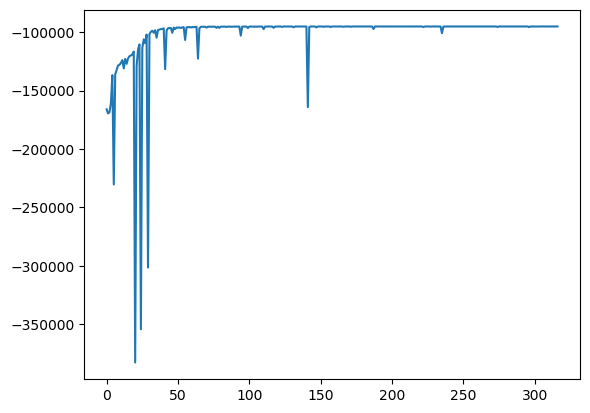

In [33]:
plot(logP);

$\lambda(1)$

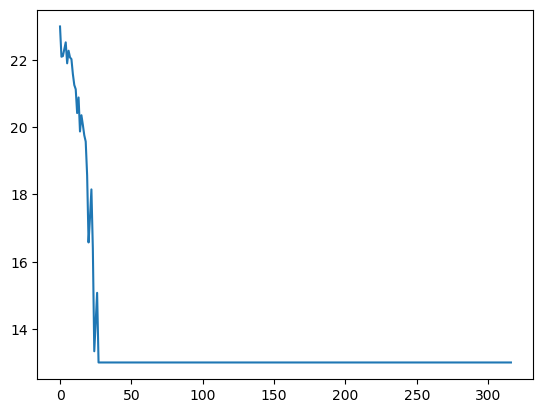

In [34]:
λ1 = map(x -> x[1], properties[1]);
plot(λ1);

$\mu$

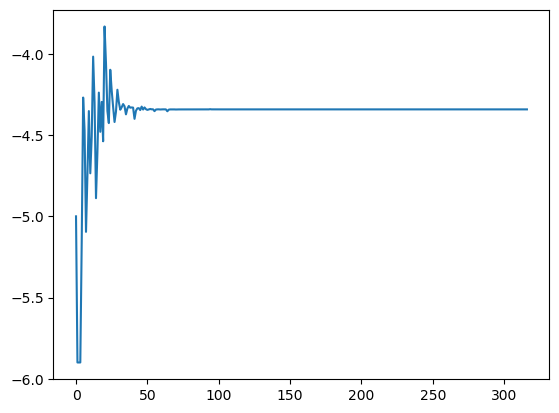

In [35]:
μ = map(x->x[1], properties[2])
plot(μ);

probability distribution:
- use the learnt model to infer the energies and probabilities of the sequences using the function `inference`
- plot the result

In [38]:
etr, ptr = inference(model, data_train); #infer energies and binding probabilities on training set

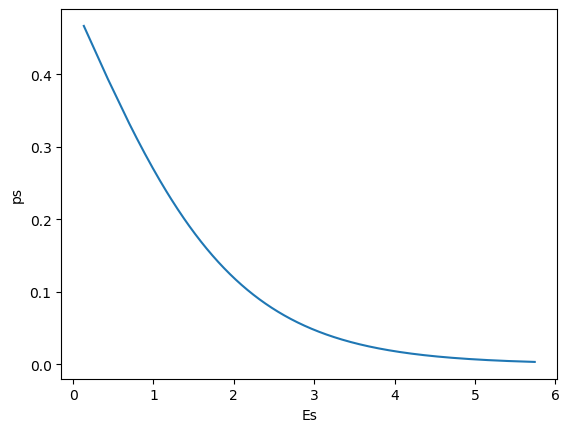

PyObject Text(24.000000000000007, 0.5, 'ps')

In [39]:
plot_distribution(etr, ptr); #plot the probability distribution

## Crossvalidation

crossvalidation can be performed in a single step by specifying all the needed parameters. Create some empty arrays to stores all the information produced during the various leanring.
- `training_set`: actual training sets and indices of the samples from the whole dataset
- `test_set`: same as above but for the test sets
- `model_parameters`: model inferred at each time a different fold is left out
- `L2reg`: priors used
- `logP`: behaviour of the loglikelihood at each learning
- `obs`: array containing all the quantities that are kept under control during the vriuos learnings. For instance `learn!` is run with `monitor=[quantity1, quantity2, ...]` and `obs[r][k]` is the value of quantity `k` when fold `r` is left out from the training set

In [40]:
training_set = [] 
test_set = []
model_parameters = []
outcomes = []
L2reg = []
logP = []
obs = []

0-element Array{Any,1}

In [42]:
prior_variance = 100.0
nfolds = 5
crossvalidation!(data, model, prior_variance, nfolds, training_set, test_set, model_parameters, outcomes, L2reg, 
    logP, obs; monitor=[get_lambda, get_mu]);

fold 1/5    ************************
fold 2/5    ************************
fold 3/5    ************************
fold 4/5    ************************
fold 5/5    ************************


## Plot some results

In [ ]:
(etr, ptr), (ete, pte) = traintest_inferenceenceenceenceence(model_parameters, data_tain, data_test)